# Build the LSLGA parent sample

The purpose of this notebook is to build the parent sample for the Legacy Surveys Galaxy Atlas (LSGA).  The final output files are:
  * large-galaxies-parent.fits -- large galaxies in the Legacy Surveys footprint
  * large-galaxies-parent-dr6-dr7.fits -- large galaxies in the DR6+DR7 footprint

Our starting catalog is the file hyperleda-d25min10.txt, which contains 2,118,186 objects and is the raw output of querying the [Hyperleda database](http://leda.univ-lyon1.fr/fullsql.html) (on 2018 May 13) for all objects with a D(25) isophotal diameter greater than 10 arcsec using the following SQL query:

```SQL
SELECT
  pgc, objname, objtype, al2000, de2000, type, bar, ring,
  multiple, compactness, t, logd25, logr25, pa, bt, it,
  kt, v, modbest
WHERE
  logd25 > 0.2218487 and (objtype='G' or objtype='M' or objtype='M2' or 
                          objtype='M3' or objtype='MG' or objtype='MC')
ORDER BY
  al2000
```

**ToDo**

1. Build unWISE and GALEX mosaics.
2. Filter and sort the sample; try to remove spurious sources.
3. Include additional metadata in the webpage.

### Imports and other preliminaries.

In [4]:
import os, sys
import time
from contextlib import redirect_stdout
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

In [5]:
import fitsio
import astropy.table
import seaborn as sns

In [6]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [7]:
sns.set(style='ticks', font_scale=1.5, palette='Set2')
%matplotlib inline

In [8]:
PIXSCALE = 0.262
mindiameter = 10 / 60  # [arcmin]
maxdiameter = 1e4    # [arcmin]

In [35]:
version = 'v1.0'
drsuffix = 'dr6-dr7'
LSLGAdir = os.getenv('LSLGA_DIR')
parentfile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-parent-{}.fits'.format(version))
samplefile = os.path.join(LSLGAdir, 'sample', 'large-galaxies-{}-{}.fits'.format(version, drsuffix))

kdparentfile = parentfile.replace('.fits', '.kd.fits')

#### Some choices.

In [10]:
rebuild_parent = False
rebuild_dr_sample = True

### Define the parent sample as the set of Hyperleda objects in the LS/DESI footprint.

We also apply minimum and maximum angular diameter cuts here.

We need to make sure the bright-star masking doesn't remove objects like [IC 2204](http://legacysurvey.org/viewer?ra=115.3331&dec=34.2240&zoom=12&layer=mzls+bass-dr6), a beautiful r=13.4 disk galaxy at a redshift of z=0.0155 with an angular diameter of approximately 1.1 arcmin.

In [11]:
def read_hyperleda():
    """Read the Hyperleda catalog.
    
    """
    hyperledafile = os.path.join(LSLGAdir, 'sample', 'hyperleda-d25min10-18may13.fits')
    allwisefile = hyperledafile.replace('.fits', '-allwise.fits')

    leda = astropy.table.Table(fitsio.read(hyperledafile, ext=1))
    leda.add_column(astropy.table.Column(name='groupid', dtype='i4', length=len(leda)))
    print('Read {} objects from {}'.format(len(leda), hyperledafile), flush=True)

    allwise = astropy.table.Table(fitsio.read(allwisefile, ext=1, lower=True))
    print('Read {} objects from {}'.format(len(allwise), allwisefile), flush=True)

    # Merge the tables
    allwise.rename_column('ra', 'wise_ra')
    allwise.rename_column('dec', 'wise_dec')
    
    leda = astropy.table.hstack( (leda, allwise) )
    leda['inwise'] = (np.array(['NULL' not in dd for dd in allwise['designation']]) * 
                      np.isfinite(allwise['w1sigm']) * np.isfinite(allwise['w2sigm']) )
    
    # Require a magnitude estimate.
    magcut = np.isfinite(leda['mag'])
    leda = leda[magcut]
    print('Removing {} objects with no magnitude estimate.'.format(np.sum(~magcut)))
    
    #print('  Identified {} objects with WISE photometry.'.format(np.sum(leda['inwise'])))
    
    return leda

In [12]:
def read_tycho(magcut=12):
    """Read the Tycho 2 catalog.
    
    """
    tycho2 = os.path.join(LSLGAdir, 'sample', 'tycho2.kd.fits')
    tycho = astropy.table.Table(fitsio.read(tycho2, ext=1, lower=True))
    tycho = tycho[np.logical_and(tycho['isgalaxy'] == 0, tycho['mag_bt'] <= magcut)]
    print('Read {} Tycho-2 stars with B<{:.1f}.'.format(len(tycho), magcut), flush=True)
    
    # Radius of influence; see eq. 9 of https://arxiv.org/pdf/1203.6594.pdf
    tycho['radius'] = (0.0802*(tycho['mag_bt'])**2 - 1.860*tycho['mag_bt'] + 11.625) / 60 # [degree]
    
    return tycho    

In [21]:
def build_parent(nside=128):
    """Identify the galaxies in the nominal LS/DESI footprint."""
    import desimodel.io
    import desimodel.footprint
    from astrometry.libkd.spherematch import tree_build_radec, tree_search_radec
        
    leda = read_hyperleda()
    
    tiles = desimodel.io.load_tiles(onlydesi=True)
    indesi = desimodel.footprint.is_point_in_desi(tiles, ma.getdata(leda['ra']), 
                                                  ma.getdata(leda['dec']))
    print('  Identified {} objects outside the DESI footprint.'.format(np.sum(~indesi)), flush=True)

    diamcut = (leda['d25'] >= mindiameter) * (leda['d25'] <= maxdiameter)
    print('  Removing {} objects with D(25) < {:.3f} and D(25) > {:.3f} arcmin.'.format(
        np.sum(~diamcut), mindiameter, maxdiameter), flush=True)

    # Reject objects classified as "g"
    # objnotg = np.hstack([np.char.strip(obj) != 'g' for obj in leda['objtype']])
    # print('  Removing {} objects with objtype == g'.format(np.sum(~objnotg)), flush=True)

    keep = np.where( diamcut )[0]
    parent = leda[keep]
    parent['in_desi'] = indesi.astype(bool)
    
    #keep = np.where( indesi * diamcut )[0]
    #parent = leda[keep]
    #print('The parent sample before star-masking has {} objects.'.format(len(parent)), flush=True)
    #print()
    
    # Next, read the Tycho2 catalog and build a KD tree to flag objects near bright stars.
    #print('Flagging galaxies near bright stars.')
    tycho = read_tycho()
    kdparent = tree_build_radec(parent['ra'], parent['dec'])

    nearstar = np.zeros( len(parent), dtype=bool)
    for star in tycho:
        I = tree_search_radec(kdparent, star['ra'], star['dec'], star['radius'])
        if len(I) > 0:
            nearstar[I] = True
    print('Found {} galaxies near a Tycho-2 star.'.format(np.sum(nearstar)), flush=True)
    parent['near_brightstar'] = nearstar.astype(bool)

    # Write out everything (do not reject) but also write out the sample near 
    # bright stars for further analysis.
    #badparent = parent[nearstar]
    #goodparent = parent[~nearstar]
    #goodparent = parent # this line, not the one above

    print('Writing {} objects to {}'.format(len(parent), parentfile), flush=True)
    parent.write(parentfile, overwrite=True)    

    #badparentfile = parentfile.replace('.fits', '-nearstars.fits')
    #print('Writing {} objects to {}'.format(len(badparent), badparentfile), flush=True)
    #badparent.write(badparentfile, overwrite=True)    
    #print()
    
    print('Writing {}'.format(kdparentfile))
    cmd = 'startree -i {} -o {} -T -P -k -n largegals'.format(parentfile, kdparentfile)
    print(cmd)
    _ = os.system(cmd)    

    return parent

In [36]:
def read_parent(parentfile, kd=True):
    """Read the previously created parent catalog.
    
    """
    from astrometry.libkd.spherematch import tree_open
    
    parent = astropy.table.Table(fitsio.read(parentfile, ext=1))
    print('Read {} objects from {}'.format(len(parent), parentfile), flush=True)
    
    if kd:
        kdparent = tree_open(kdparentfile, 'largegals')
        return parent, kdparent
    else:
        return parent

In [23]:
if rebuild_parent:
    parentlogfile = os.path.join(LSLGAdir, 'sample', 'build-parent-{}.log'.format(version))
    print('Building the parent sample (version {})'.format(version))
    print('Logging to {}'.format(parentlogfile))
    t0 = time.time()
    with open(parentlogfile, 'w') as log:
        with redirect_stdout(log):
            parent = build_parent()
            print('Total time = {:.3f} min.'.format( (time.time() - t0) / 60 ), flush=True)
    with open(parentlogfile, 'r') as log:
        print(log.read())    

In [37]:
parent, kdparent = read_parent(parentfile, kd=True)
parent

Read 1363748 objects from /global/cscratch1/sd/ioannis/LSLGA/sample/large-galaxies-parent-v1.0.fits


galaxy,pgc,objtype,ra,dec,type,bar,ring,multiple,compactness,t,d25,ba,pa,bt,it,kt,modbest,z,sb_d25,mag,groupid,designation,wise_ra,wise_dec,cntr,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,w4mpro,w4sigmpro,nb,na,cc_flags,ext_flg,ph_qual,w1mag,w1sigm,w2mag,w2sigm,w3mag,w3sigm,w4mag,w4sigm,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,inwise,in_desi,near_brightstar
bytes28,int64,bytes2,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes20,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,bool,bool,bool
PGC639648,639648,G,0.0003765,-36.1988588,nan,nan,nan,nan,nan,nan,0.213796,0.891251,100.0,18.58,nan,nan,nan,nan,23.8585,18.58,0,J000000.04-361155.2,0.0001762,-36.1986875,36401351031683,15.624,0.039,15.286,0.074,11.441,0.138,8.682,nan,1,0,0000,0,AABU,15.33,0.031,15.044,0.079,11.375,0.14,8.626,0.359,0,nan,nan,nan,nan,nan,nan,True,False,False
PGC622563,622563,G,0.000474,-37.4760687,nan,nan,nan,nan,nan,nan,0.295121,0.758578,128.0,17.75,15.835,13.442,nan,nan,23.7285,17.75,0,J000000.11-372834.6,0.0004772,-37.4762838,37901351043221,13.59,0.025,13.489,0.03,12.717,0.436,9.121,nan,1,0,0000,1,AACU,13.333,0.011,13.24,0.022,12.184,0.427,8.64,nan,555089782,15.626,0.101,14.775,0.096,14.377,0.093,True,False,False
PGC1982072,1982072,G,0.000603,32.1365967,nan,nan,nan,nan,nan,nan,0.323594,0.74131,136.5,17.78,nan,13.728,nan,nan,23.9585,17.78,0,J000000.08+320811.7,0.0003588,32.1366072,131801351041012,13.953,0.027,13.699,0.034,9.883,0.047,7.525,0.126,1,0,d000,1,AAAB,13.711,0.016,13.506,0.03,9.725,0.046,7.504,0.18,338226820,15.945,0.096,15.256,0.127,14.795,0.135,True,True,False
PGC535833,535833,G,0.00066,-44.577893,nan,nan,nan,nan,nan,nan,0.334965,0.582103,148.5,17.63,17.135,nan,nan,nan,23.8835,17.63,0,J000000.15-443440.8,0.0006345,-44.5780196,44001351005367,15.497,0.041,15.269,0.083,12.006,0.318,8.353,nan,1,0,0000,0,AABU,15.224,0.044,15.093,0.139,11.777,0.286,8.074,nan,0,nan,nan,nan,nan,nan,nan,True,False,False
SDSSJ000000.16-001108.5,4165833,G,0.000702,-0.1857632,nan,nan,nan,nan,nan,nan,0.180717,0.907821,nan,18.873,17.503,nan,39.84,0.195055,23.7865,18.873,0,J000000.16-001108.6,0.0007006,-0.18574,100001351018364,14.58,0.032,13.951,0.042,10.355,0.075,8.014,0.252,1,0,0000,0,AAAB,14.52,0.056,13.896,0.052,10.357,0.11,7.693,nan,0,nan,nan,nan,nan,nan,nan,True,True,False
PGC520795,520795,G,0.0007365,-45.9540486,nan,nan,nan,nan,nan,nan,0.338844,0.668344,24.68,17.54,15.5,13.341,nan,nan,23.8185,17.54,0,J000000.14-455715.2,0.0005894,-45.9542465,45501351005362,13.482,0.024,13.31,0.03,12.317,0.43,8.655,nan,1,0,0000,1,AACU,13.226,0.011,13.066,0.032,12.014,0.364,8.294,nan,572925716,15.409,0.086,14.683,0.09,14.122,0.086,True,False,False
PGC1961515,1961515,G,0.000762,31.7311001,nan,nan,nan,nan,nan,nan,0.39355,0.609537,160.33,17.38,nan,13.47,nan,nan,23.9835,17.38,0,J000000.15+314351.3,0.0006609,31.7309335,131801351028798,14.018,0.039,13.906,0.049,10.515,0.098,8.475,0.503,2,1,0000,4,AAAC,13.346,0.015,13.268,0.029,9.894,0.058,8.404,0.424,338227585,15.632,0.089,15.001,0.112,14.616,0.129,True,True,True
PGC228194,228194,G,0.0009555,-80.2419449,nan,nan,nan,nan,nan,nan,0.331131,0.707946,175.0,17.78,15.61,13.455,nan,nan,24.0085,17.78,0,J000000.13-801430.8,0.0005599,-80.2418934,80301351031314,13.433,0.024,13.266,0.025,10.543,0.061,8.612,0.306,1,0,0000,5,AAAB,13.266,0.008,13.104,0.02,10.346,0.057,8.084,nan,718175333,15.536,0.084,14.633,0.116,14.37,0.097,True,False,False
PGC124374,124374,G,0.0012825,-41.4229345,nan,nan,nan,nan,nan,nan,0.37325,0.952796,nan,16.98,15.05,13.25,37.165,0.06167,23.4685,16.98,0,J000000.28-412522.3,0.0011826,-41.4228663,40901351005636,13.266,0.025,13.259,0.029,12.201,nan,9.098,nan,1,0,d000,1,AAUU,13.058,0.008,13.053,0.02,11.925,nan,8.116,

In [28]:
leda = read_hyperleda()

Read 1376864 objects from /global/cscratch1/sd/ioannis/LSLGA/sample/hyperleda-d25min10-18may13.fits
Read 1376864 objects from /global/cscratch1/sd/ioannis/LSLGA/sample/hyperleda-d25min10-18may13-allwise.fits
Removing 13116 objects with no magnitude estimate.


#### Some sanity QA.

In [26]:
def qa_mag_d25(cat, supercat):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.hexbin(supercat['mag'], np.log10(supercat['d25']), extent=(0, 25, -1, 3),
              mincnt=1, cmap='viridis')
    ax.scatter(cat['mag'], np.log10(cat['d25']), s=5)
    #ax.hexbin(cat['mag'], np.log10(cat['d25']), extent=(5, 23, -1, 2),
    #          mincnt=1, cmap='viridis')
    ax.axhline(y=np.log10(10 / 60), ls='-', lw=2, color='k', alpha=0.8)
    #ax.axhline(y=np.log10(mindiameter), ls='--', lw=2, color='red', alpha=0.8)
    #ax.axhline(y=np.log10(maxdiameter), ls='--', lw=2, color='red', alpha=0.8)
    ax.set_xlabel('B mag')
    ax.set_ylabel(r'$\log_{10}\, D_{25}$ (arcmin)')

In [29]:
def qa_radec_parent(parent):
    indesi = parent['in_desi']
    outdesi = ~indesi
    nearstar = parent['near_brightstar']

    fig, ax = plt.subplots()
    ax.scatter(parent['ra'][outdesi], parent['dec'][outdesi], s=5, label='Outside DESI')
    ax.scatter(parent['ra'][indesi], parent['dec'][indesi], s=5, label='In DESI')
    ax.scatter(parent['ra'][nearstar], parent['dec'][nearstar], 
               s=1, color='k', label='Near Bright Star')
    #ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR7')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.set_xlim(360, 0)
    ax.set_ylim(-90, 120)
    ax.legend(loc='upper left', fontsize=10, frameon=True, ncol=3)

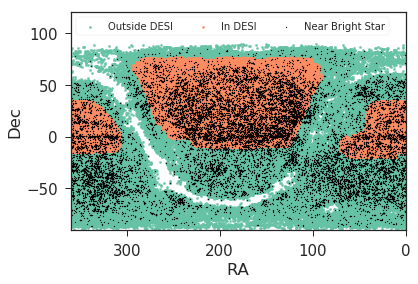

In [30]:
qa_radec_parent(parent)

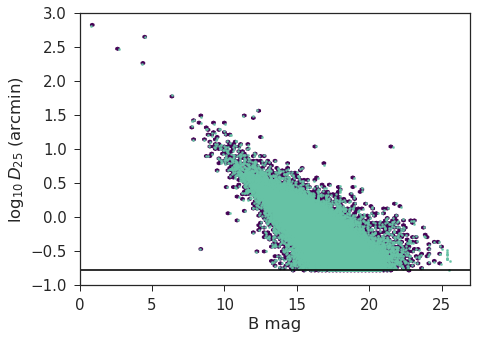

In [31]:
qa_mag_d25(parent, leda)

In [32]:
# This fails because of a matplotlib, basemap collision.
#from LSLGA.qa import qa_binned_radec
#qa_binned_radec(parent)

### Identify the galaxies in the DR6/DR7 footprint.

In [33]:
#from astrometry.libkd.spherematch import tree_open, tree_search_radec, tree_build_radec, trees_match
#fn = '/project/projectdirs/cosmo/data/legacysurvey/dr7/survey-ccds-dr7.kd.fits'
#kd = tree_open(fn, 'ccds')
#kd2 = tree_build_radec(parent['ra'], parent['dec'])
#I, J, dist, counts = trees_match(kd, kd2, np.radians(1), count=True)

In [ ]:
#I, J, dist, counts = trees_match(kdccds, kdparent, np.radians(1), count=True)

In [57]:
#from astrometry.libkd.spherematch import tree_open, tree_search_radec, trees_match
#ccdsfile = '/project/projectdirs/cosmo/data/legacysurvey/dr7/survey-ccds-dr7.kd.fits'
#ccds = astropy.table.Table(fitsio.read(ccdsfile, ext=1))
#print('Read {} CCDs from {}'.format(len(ccds), ccdsfile))
#kdccds = tree_open('/project/projectdirs/cosmo/data/legacysurvey/dr7/survey-ccds-dr7.kd.fits', 'ccds')
#for gal in parent:
#    I = tree_search_radec(ccdsdr7, gal['ra'], gal['dec'], gal['d25']/60)
#    if len(I) > 0:
#        import pdb ; pdb.set_trace()
#kd = tree_open(fn, 'ccds')
#I, J, dist, counts = trees_match(kd, kd2, np.radians(1), count=True)

In [58]:
from legacypipe.survey import LegacySurveyData
from astrometry.libkd.spherematch import tree_open
survey_dr6 = LegacySurveyData(survey_dir='/global/cscratch1/sd/dstn/dr6plus')
survey_dr7 = LegacySurveyData(survey_dir='/global/cscratch1/sd/desiproc/dr7')

In [59]:
def simple_wcs(onegal, diam):
    """Build a simple WCS object for a single group.
    
    """
    from astrometry.util.util import Tan
    size = np.rint(diam * 60 / PIXSCALE).astype('int') # [pixels]
    wcs = Tan(onegal['ra'], onegal['dec'], size/2+0.5, size/2+0.5,
                 -PIXSCALE/3600.0, 0.0, 0.0, PIXSCALE/3600.0, 
                 float(size), float(size))
    return wcs

In [60]:
def _build_sample_one(args):
    """Wrapper function for the multiprocessing."""
    return build_sample_one(*args)

In [75]:
def get_masked_pixels(ccds, survey, wcs):
    """Compute the fraction of masked pixels."""
    W, H = wcs.get_width(), wcs.get_height()
    radecpoly = targetrd = np.array([wcs.pixelxy2radec(x,y) for x, y in
                                             [(1, 1), (W, 1), (W, H), (1, H), (1, 1)]])
    
    for ii, ccd in enumerate(ccds):
        im = survey.get_image_object(ccd)
        x0, x1, y0, y1, slc = im.get_image_extent(wcs=wcs, radecpoly=radecpoly)
        dq = im.read_dq(slice=slc)
        frac = np.sum(dq & 4)/dq.size
        print(ii, ccd.filter, 100 * frac)
        plt.imshow(dq, origin='lower')
        plt.show()
        #import pdb ; pdb.set_trace()
    #return frac

In [76]:
def build_sample_one(onegal, verbose=False):
    """Wrapper function to find overlapping grz CCDs for a given group.
    
    """
    
    diam = onegal['d25'] # [arcmin]
    
    wcs = simple_wcs(onegal, diam)
    
    ccds = survey_dr7.ccds_touching_wcs(wcs, ccdrad=None)
    if ccds is not None:
        dr = 'dr7'
        survey = survey_dr7
    else:
        ccds = survey_dr6.ccds_touching_wcs(wcs, ccdrad=None)
        if ccds is not None:
            dr = 'dr6'
            survey = survey_dr6
        else:
            return [None, None]
        
    if ccds is not None:
        # Is there 3-band coverage?
        if 'g' in ccds.filter and 'r' in ccds.filter and 'z' in ccds.filter:
            get_masked_pixels(ccds, survey, wcs)
            if verbose:
                print('Galaxy {:08d}: {} CCDs, RA = {:.5f}, Dec = {:.5f}, Diameter={:.4f} arcmin'.format(
                        onegal['galaxy'], len(ccds), onegal['ra'], onegal['dec'], diam))
                sys.stdout.flush()
            return [dr, onegal]
    #return [None, None]

In [77]:
def build_sample(cat, use_nproc=nproc):
    """Build the full sample with grz coverage in DR6+DR7.
    
    """
    sampleargs = list()
    for gg in cat:
        sampleargs.append( (gg, True) ) # the False refers to verbose=False

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        result = p.map(_build_sample_one, sampleargs)
        p.close()
    else:
        result = list()
        for args in sampleargs:
            result.append(_build_sample_one(args))
            
    # Remove non-matching objects and write out the sample
    rr = list(zip(*result))    
    import pdb ; pdb.set_trace()
    
    outcat = astropy.table.vstack(list(filter(None, rr[1])))
    outcat['dr'] = list(filter(None, rr[0]))
    print('Found {}/{} objects in the DR6/DR7 footprint.'.format(len(outcat), len(cat)))
    
    return outcat

Searching /global/cscratch1/sd/desiproc/dr7/survey-ccds-dr7.kd.fits
0 CCDs within 1.0 deg of RA,Dec (94.657, 78.357)
Searching /global/cscratch1/sd/dstn/dr6plus/survey-ccds-dr6plus.kd.fits
115 CCDs within 1.0 deg of RA,Dec (94.657, 78.357)
Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/mosaic/CP20170930/k4m_171001_092154_ood_zd_v1.fits.fz ext 1
0 z 0.44598451758


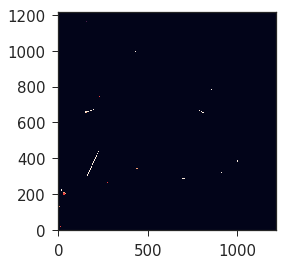

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/mosaic/CP20170930/k4m_171001_081226_ood_zd_v1.fits.fz ext 1
1 z 0.637622713316


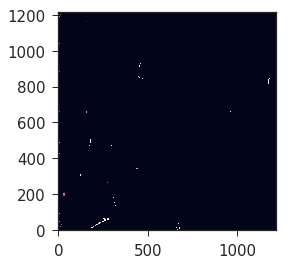

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/90prime/CP20170202/ksb_170203_021455_ood_r_v1.fits.fz ext 2
2 r 0.235155472906


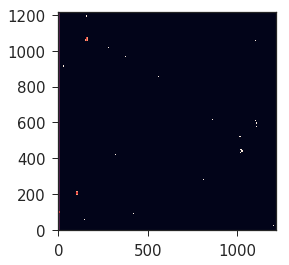

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/90prime/CP20170202/ksb_170203_020435_ood_r_v1.fits.fz ext 2
3 r 0.200828179734


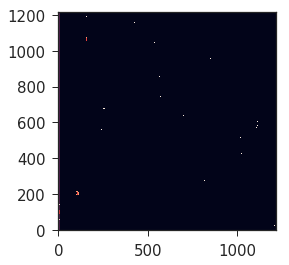

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/90prime/CP20160103/ksb_160104_040820_ood_g_v1.fits.fz ext 2
4 g 0.592213380617


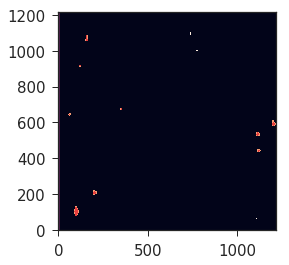

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/90prime/CP20160103/ksb_160104_042001_ood_g_v1.fits.fz ext 2
5 g 0.63546036414


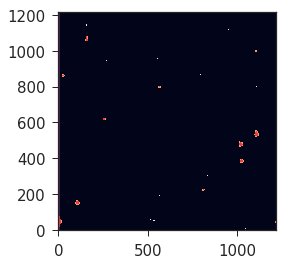

Reading data quality image /global/cscratch1/sd/dstn/dr6plus/images/mosaic/CP20170306/k4m_170307_030234_ood_zd_v1.fits.fz ext 2
6 z 1.48337153484


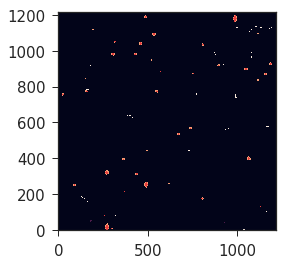

In [78]:
#sample = build_sample_one(parent[4264])
sample = build_sample_one(parent[321089])

In [ ]:
parent[321089]

In [ ]:
w1 = np.where( parent['in_desi'] == 0)[0]
pp = parent[w1]
ww = np.where( ['NGC2146' in gg.decode('utf-8').strip() for gg in pp['galaxy'].data] )[0] # [:10000]] )[0]
print(w1[ww])
#print(parent['galaxy'][w1[ww]][7], w1[ww][7])
pp[ww]

In [ ]:
stop

In [ ]:
#%time groupsample = build_sample(groupcat[:500])

In [ ]:
if rebuild_dr_sample:
    samplelogfile = os.path.join(LSLGAdir, 'sample', 'build-sample-{}.log'.format(drsuffix))
    print('Building the sample.')
    print('Logging to {}'.format(samplelogfile))
    t0 = time.time()
    with open(samplelogfile, 'w') as log:
        with redirect_stdout(log):
            groupsample = build_sample(groupcat)
    print('Found {}/ {} groups in the LS footprint.'.format(len(groupsample), len(groupcat)))
    print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ) )
else:
    

#### Cross-reference the group catalog to the parent sample and then write out.

In [ ]:
sample = parentcat[np.where( np.in1d( parentcat['groupid'], groupsample['groupid']) )[0]]
print('Writing {}'.format(samplefile))
sample.write(samplefile, overwrite=True)

print('Writing {}'.format(groupsamplefile))
groupsample.write(groupsamplefile, overwrite=True)

#### Some sanity QA

In [ ]:
def qa_radec_dr(parent, sample):
    idr5 = sample['dr'] == 'dr5'
    idr6 = sample['dr'] == 'dr6'
    idr7 = sample['dr'] == 'dr7'

    fig, ax = plt.subplots()
    ax.scatter(parent['ra'], parent['dec'], alpha=0.5, s=5, label='Parent Catalog')
    ax.scatter(sample['ra'][idr5], sample['dec'][idr5], s=10, label='In DR5')
    ax.scatter(sample['ra'][idr6], sample['dec'][idr6], s=10, label='In DR6')
    #ax.scatter(sample['ra'][idr7], sample['dec'][idr7], s=10, label='In DR7')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.legend(loc='upper left', fontsize=10, frameon=True)#, ncol=3)

In [ ]:
qa_radec_dr(groupcat, groupsample)

In [ ]:
stop

In [ ]:
leda[leda['d25'] > 0.5]

### Get viewer cutouts of a subset of the groups.

In [ ]:
sample = astropy.table.Table.read(samplefile)
groupsample = astropy.table.Table.read(groupsamplefile)

In [ ]:
ww = ['g' in oo for oo in sample['objtype']]
sample[ww]

In [ ]:
jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
if not os.path.isdir(jpgdir):
    os.mkdir(jpgdir)

In [ ]:
def get_groupname(group):
    return 'group{:08d}-n{:03d}'.format(group['groupid'], group['nmembers'])

In [ ]:
def get_layer(group):
    if group['dr'] == 'dr6':
        layer = 'mzls+bass-dr6'
    elif group['dr'] == 'dr5':
        layer = 'decals-dr5'
    elif group['dr'] == 'dr7':
        layer = 'decals-dr5'
    return layer

In [ ]:
def _get_cutouts_one(args):
    """Wrapper function for the multiprocessing."""
    return get_cutouts_one(*args)

In [ ]:
def get_cutouts_one(group, clobber=False):
    """Get viewer cutouts for a single galaxy."""

    layer = get_layer(group)
    groupname = get_groupname(group)
        
    diam = group_diameter(group) # [arcmin]
    size = np.ceil(diam * 60 / PIXSCALE).astype('int') # [pixels]

    imageurl = '{}/?ra={:.8f}&dec={:.8f}&pixscale={:.3f}&size={:g}&layer={}'.format(
        cutouturl, group['ra'], group['dec'], PIXSCALE, size, layer)
        
    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    cmd = 'wget --continue -O {:s} "{:s}"' .format(jpgfile, imageurl)
    if os.path.isfile(jpgfile) and not clobber:
        print('File {} exists...skipping.'.format(jpgfile))
    else:
        if os.path.isfile(jpgfile):
            os.remove(jpgfile)
        print(cmd)
        os.system(cmd)
    #sys.stdout.flush()
            
    # Get the fraction of masked pixels
    #im = np.asarray( Image.open(jpgfile) )
    #area = np.product(im.shape[:2])
    #fracmasked = ( np.sum(im[:, :, 0] == 32) / area, 
    #               np.sum(im[:, :, 1] == 32) / area,
    #               np.sum(im[:, :, 2] == 32) / area )
    
    return #np.max(fracmasked)

In [ ]:
def get_cutouts(groupsample, use_nproc=nproc, clobber=False):
    """Get viewer cutouts of the whole sample."""

    cutoutargs = list()
    for gg in groupsample:
        cutoutargs.append( (gg, clobber) )

    if use_nproc > 1:
        p = multiprocessing.Pool(nproc)
        p.map(_get_cutouts_one, cutoutargs)
        p.close()
    else:
        for args in cutoutargs:
            _get_cutouts_one(args)

    return

In [ ]:
nmin = 2
indx = groupsample['nmembers'] >= nmin
print('Getting cutouts of {} groups with >={} member(s).'.format(np.sum(indx), nmin))
#groupsample['fracmasked'][indx] = get_cutouts(groupsample[indx], clobber=True)#, use_nproc=1)

In [ ]:
#get_cutouts_one(groupsample[0], clobber=False)

In [ ]:
cutlogfile = os.path.join(LSLGAdir, 'cutouts', 'get-cutouts-{}.log'.format(drsuffix))
print('Getting viewer cutouts.')
print('Logging to {}'.format(cutlogfile))
t0 = time.time()
with open(cutlogfile, 'w') as log:
    with redirect_stdout(log):
        get_cutouts(groupsample[indx], clobber=False)
print('Total time = {:.3f} minutes.'.format( (time.time() - t0) / 60 ))

#### Add labels and a scale bar.

In [ ]:
barlen = np.round(60.0 / PIXSCALE).astype('int') # [1 arcmin in pixels]
fonttype = os.path.join(LSLGAdir, 'cutouts', 'Georgia.ttf')

In [ ]:
def get_galaxy(group, sample, html=False):
    """List the galaxy name.
    
    """
    these = group['groupid'] == sample['groupid']
    galaxy = [gg.decode('utf-8').strip().lower() for gg in sample['galaxy'][these].data]
    
    if html:
        galaxy = ' '.join(np.sort(galaxy)).upper()
    else:
        galaxy = ' '.join(np.sort(galaxy))

    return galaxy

In [ ]:
def _add_labels_one(args):
    """Wrapper function for the multiprocessing."""
    return add_labels_one(*args)

In [ ]:
def add_labels_one(group, sample, clobber=False, nothumb=False):

    jpgdir = os.path.join(LSLGAdir, 'cutouts', 'jpg')
    pngdir = os.path.join(LSLGAdir, 'cutouts', 'png')
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    groupname = get_groupname(group)
    galaxy = get_galaxy(group, sample, html=True)

    jpgfile = os.path.join(jpgdir, '{}.jpg'.format(groupname))
    pngfile = os.path.join(pngdir, '{}.png'.format(groupname))
    thumbfile = os.path.join(pngdir, 'thumb-{}.png'.format(groupname))
    
    if os.path.isfile(jpgfile):
        if os.path.isfile(pngfile) and not clobber:
            print('File {} exists...skipping.'.format(pngfile))
        else:
            im = Image.open(jpgfile)
            sz = im.size
            fntsize = np.round(sz[0]/28).astype('int')
            width = np.round(sz[0]/175).astype('int')
            font = ImageFont.truetype(fonttype, size=fntsize)
            draw = ImageDraw.Draw(im)

            # Label the group--
            draw.text((0+fntsize*2, 0+fntsize*2), galaxy, font=font)
    
            # Add a scale bar--
            x0, x1, yy = sz[1]-fntsize*2-barlen, sz[1]-fntsize*2, sz[0]-fntsize*2
            draw.line((x0, yy, x1, yy), fill='white', width=width)
            im.save(pngfile)    
        
            # Generate a thumbnail
            if not nothumb:
                cmd = 'convert -thumbnail 300x300 {} {}'.format(pngfile, thumbfile)
                os.system(cmd)

In [ ]:
def add_labels(groupsample, sample, clobber=False):
    labelargs = list()
    for group in groupsample:
        labelargs.append((group, sample, clobber))
    if nproc > 1:
        p = multiprocessing.Pool(nproc)
        res = p.map(_add_labels_one, labelargs)
        p.close()
    else:
        for args in labelargs:
            res = _add_labels_one(args)

In [ ]:
%time add_labels(groupsample, sample, clobber=True)

In [ ]:
#add_labels_one(groupsample[10], sample, clobber=True)

### Finally, assemble the webpage of good and rejected gallery images.

To test the webpage before release, do

```bash
 rsync -auvP $LLSLGLSLGLSLGALSLGALSLGAA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
or
```bash
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/png /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
 rsync -auvP /global/cscratch1/sd/ioannis/LSLGA/cutouts/*.html /global/project/projectdirs/cosmo/www/temp/ioannis/LSLGA/
```
and then the website can be viewed here:
  http://portal.nersc.gov/project/cosmo/temp/ioannis/LSLGA    

In [ ]:
reject = []
toss = np.zeros(len(groupsample), dtype=bool)
for ii, gg in enumerate(groupsample['groupid']):
    for rej in np.atleast_1d(reject):
        toss[ii] = rej in gg.lower()
        if toss[ii]:
            break
print('Rejecting {} groups.'.format(np.sum(toss)))
groupkeep = groupsample[~toss]
if np.sum(toss) > 0:
    grouprej = groupsample[toss]
else:
    grouprej = []

In [ ]:
def html_rows(_groupkeep, sample, nperrow=4):
    
    # Not all objects may have been analyzed.
    these = [os.path.isfile(os.path.join(LSLGAdir, 'cutouts', 'png', '{}.png'.format(
        get_groupname(gg)))) for gg in _groupkeep]
    groupkeep = _groupkeep[these]
    
    nrow = np.ceil(len(groupkeep) / nperrow).astype('int')
    groupsplit = list()
    for ii in range(nrow):
        i1 = nperrow*ii
        i2 = nperrow*(ii+1)
        if i2 > len(groupkeep):
            i2 = len(groupkeep)
        groupsplit.append(groupkeep[i1:i2])
    print('Splitting the sample into {} rows with {} mosaics per row.'.format(nrow, nperrow))

    html.write('<table class="ls-gallery">\n')
    html.write('<tbody>\n')
    for grouprow in groupsplit:
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = get_galaxy(group, sample, html=True)

            pngfile = os.path.join('cutouts', 'png', '{}.png'.format(groupname))
            thumbfile = os.path.join('cutouts', 'png', 'thumb-{}.png'.format(groupname))
            img = 'src="{}" alt="{}"'.format(thumbfile, galaxy)
            #img = 'class="ls-gallery" src="{}" alt="{}"'.format(thumbfile, nicename)
            html.write('<td><a href="{}"><img {}></a></td>\n'.format(pngfile, img))
        html.write('</tr>\n')
        html.write('<tr>\n')
        for group in grouprow:
            groupname = get_groupname(group)
            galaxy = '{}: {}'.format(groupname.upper(), get_galaxy(group, sample, html=True))
            layer = get_layer(group)
            href = '{}/?layer={}&ra={:.8f}&dec={:.8f}&zoom=12'.format(viewerurl, layer, group['ra'], group['dec'])
            html.write('<td><a href="{}" target="_blank">{}</a></td>\n'.format(href, galaxy))
        html.write('</tr>\n')
    html.write('</tbody>\n')            
    html.write('</table>\n')

In [ ]:
with open(htmlfile, 'w') as html:
    html.write('<html><head>\n')
    html.write('<style type="text/css">\n')
    html.write('table.ls-gallery {width: 90%;}\n')
    #html.write('img.ls-gallery {display: block;}\n')
    #html.write('td.ls-gallery {width: 100%; height: auto}\n')
    #html.write('td.ls-gallery {width: 100%; word-wrap: break-word;}\n')
    html.write('p.ls-gallery {width: 80%;}\n')
    html.write('</style>\n')
    html.write('</head><body>\n')
    html.write('<h1>Legacy Surveys Large Galaxy Atlas</h1>\n')
    html.write("""<p class="ls-gallery">Each thumbnail links to a larger image while the galaxy 
    name below each thumbnail links to the <a href="http://legacysurvey.org/viewer">Sky Viewer</a>.  
    For reference, the horizontal white bar in the lower-right corner of each image represents 
    one arcminute.</p>\n""")
    #html.write('<h2>Large Galaxy Sample</h2>\n')
    html_rows(groupkeep, sample)
    html.write('</body></html>\n')

In [ ]:
if len(grouprej) > 0:
    with open(htmlfile_reject, 'w') as html:
        html.write('<html><head>\n')
        html.write('<style type="text/css">\n')
        html.write('img.ls-gallery {display: block;}\n')
        html.write('td.ls-gallery {width: 20%; word-wrap: break-word;}\n')
        html.write('</style>\n')
        html.write('</head><body>\n')
        html.write('<h1>Large Galaxies - Rejected</h1>\n')
        html_rows(grouprej, sample)
        html.write('</body></html>\n')

In [ ]:
stop

In [ ]:
#ww = np.where(['NGC' in gg for gg in parent['galaxy']])[0]
#[print(gg.decode('utf-8'), rr, dd) for (gg, rr, dd) in zip(parent['galaxy'][ww].data, parent['ra'][ww].data, parent['dec'][ww].data)]
#print(ww[4])
#parent[ww]